In [1]:
import numpy as np
import pandas as pd

In [134]:
# reading all the tweets
campaign_tweets = pd.read_csv('archive/Twitter/AbbottCampaign-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title', 'Date'])
gov_tweets = pd.read_csv('archive/Twitter/GovAbbott-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title', 'Date'])
abbot_tweets = pd.read_csv('archive/Twitter/GregAbbott_TX-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title', 'Date'])

In [135]:
campaign_tweets.head()

Publication Year                               Author  \
0              2021                    Texans for Abbott   
1              2021                    Texans for Abbott   
2              2021                    Texans for Abbott   
3              2021                    Texans for Abbott   
4              2023  Texans for Abbott [@AbbottCampaign]   

                                               Title Publication Title  \
0  'Operation Lone Star Has Seized Thousands of P...   @AbbottCampaign   
1  Since launching Operation Lone Star, @TxDPS & ...   @AbbottCampaign   
2  Since Operation Lone Star began @TxDPS has mad...   @AbbottCampaign   
3  Today @GregAbbott_TX announced the expansion o...   @AbbottCampaign   
4  Texas has done more than ANY state in history ...           Twitter   

        Date  
0  8/30/2021  
1  4/30/2021  
2   4/1/2021  
3  3/17/2021  
4  2/26/2023

In [136]:
campaign_tweets.groupby(['Author']).count()

Publication Year  Title  \
Author                                                         
Texans for Abbott                                   4      4   
Texans for Abbott [@AbbottCampaign]                24     24   

                                     Publication Title  Date  
Author                                                        
Texans for Abbott                                    4     4  
Texans for Abbott [@AbbottCampaign]                 24    24

In [137]:
# fixing author so its standard 
mask = abbot_tweets['Author'].str.contains(r'\AGreg Abbott\Z')
abbot_tweets.loc[mask, 'Author'] = abbot_tweets.loc[mask, 'Author'].str.replace('Greg Abbott', 'Greg Abbott [@GregAbbott_TX]')

mask = campaign_tweets['Author'].str.contains(r'\ATexans for Abbott\Z')
campaign_tweets.loc[mask, 'Author'] = campaign_tweets.loc[mask, 'Author'].str.replace('Texans for Abbott', 'Texans for Abbott [@AbbottCampaign]')

In [140]:
campaign_tweets.groupby(['Author']).count()

Publication Year  Title  \
Author                                                         
Texans for Abbott [@AbbottCampaign]                28     28   

                                     Publication Title  Date  
Author                                                        
Texans for Abbott [@AbbottCampaign]                 28    28

In [142]:
# combine the three lists into one
tweets = pd.concat([abbot_tweets, gov_tweets, campaign_tweets], ignore_index=True)
tweets.groupby(['Author']).count()['Title']

Author
Gov. Greg Abbott [@GovAbbott]          91
Greg Abbott [@GregAbbott_TX]           68
Texans for Abbott [@AbbottCampaign]    28
Name: Title, dtype: int64

In [8]:
tweets[tweets['Publication Year'] == 2021].count()['Title']

38

In [9]:
years = [2021, 2022, 2023]
abbot_dict = {}

for year in years:
    text_year = " ".join(tweets[tweets['Publication Year'] == year]['Title'])
    abbot_dict[year] = text_year.lower()

In [10]:
def rep(s, words):
    for key in words:
        for value in words[key]:
            s = s.replace(value, key)
    return s

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'tx', 'operation', 'lone', 'star', 'state', 'said', 'austin', 'greg', 'every', 'accross', 'since', 'lbs',
             'administration', 'it', 'along', 'olivarez', 'also', 'p', 'https', 'co', 'operationlonestar', 'pres', 'continue'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
# tokenizer = RegexpTokenizer(r'\b(?!https)\w+\b')

pattern = [r'\bfox\snews\b', r'\brio\sgrande\b', r'\bnational\sguard\b']
year_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'abbott': ['gregabbott_tx', 'governor abbott', 'governor'],
    'biden': ['president biden', 'president'],
    'trafficking': ['human trafficking'],
    'lieutenant': ['lt'],
    'continue': ['continues']
}

for year, text in abbot_dict.items():
    
    # replace similar words and phrases together
    t = re.sub(r"http\S+", "", text)
    t = rep(t, words_to_replace)
    
    tokens = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(tokens)):
        if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        elif i < len(tokens)-1 and re.match(pattern[1], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        elif i < len(tokens)-1 and re.match(pattern[2], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        else:
            new_tokens.append(tokens[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    year_freqs[year] = fdist
    
    
for k, v in year_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

2021 :
border: 53
dps: 22
secure: 18
guard: 17
biden: 14
illegal: 13
national guard: 12
safe: 12
immigrants: 11
keep: 9

2022 :
border: 147
biden: 87
secure: 48
fentanyl: 45
migrants: 43
communities: 32
dps: 32
doses: 30
seized: 30
criminal: 29

2023 :
border: 39
biden: 26
deadly: 18
abbott: 16
secure: 14
fentanyl: 11
illegal: 10
seized: 10
doses: 10
drugs: 10



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'

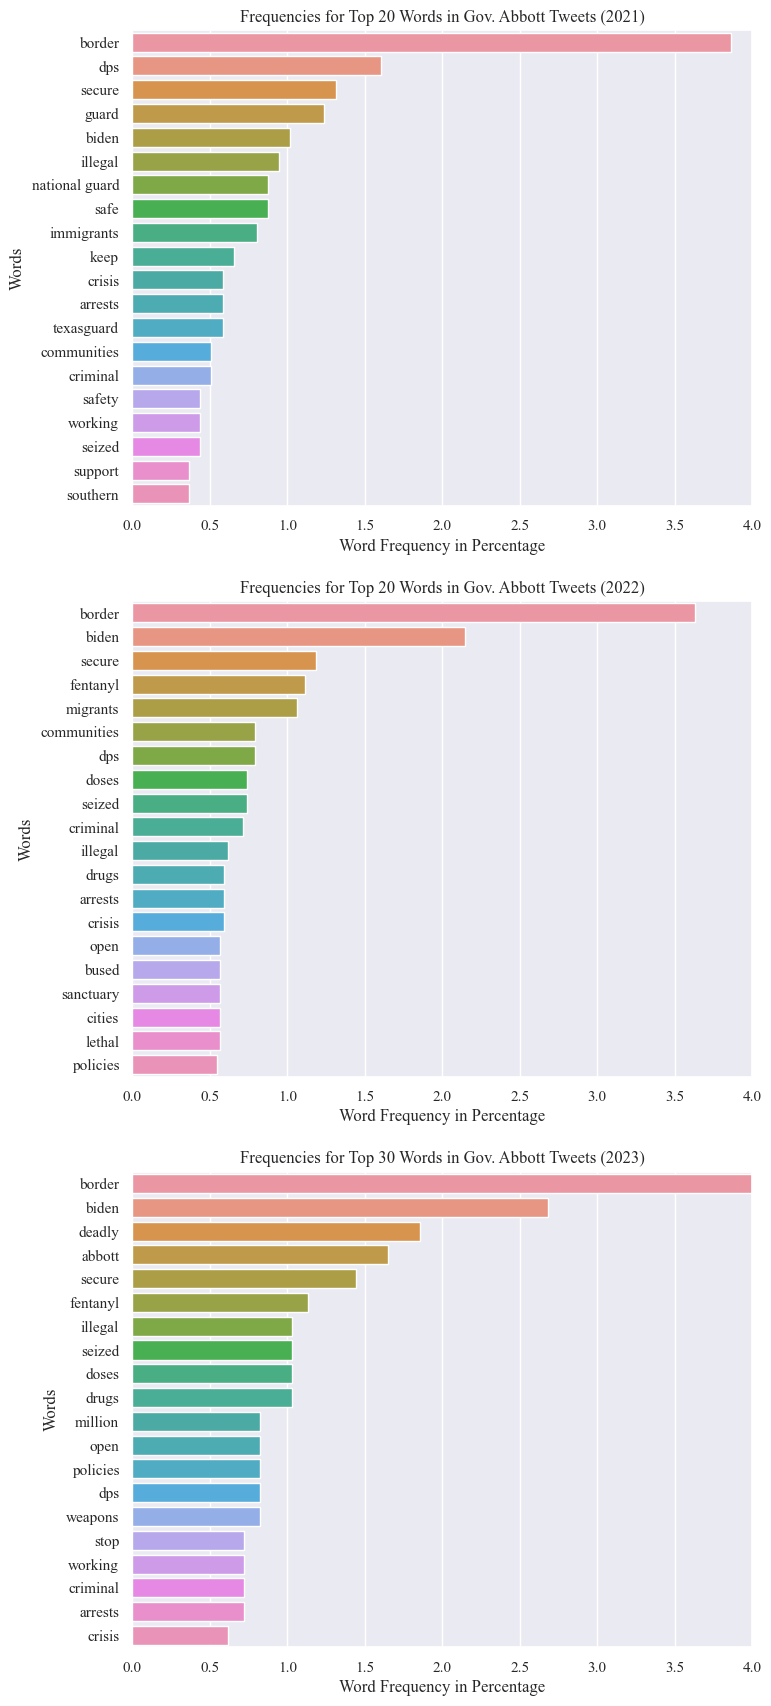

In [13]:
top_words_2021 = [(k ,(v/total_words[0])*100) for k, v in year_freqs[2021].most_common(20)]
top_words_2022 = [(k ,(v/total_words[1])*100) for k, v in year_freqs[2022].most_common(20)]
top_words_2023 = [(k ,(v/total_words[2])*100) for k, v in year_freqs[2023].most_common(20)]
sns.set(font='Times New Roman')

# Create a bar plot of the most common words
fig, axes = plt.subplots(3,1,figsize=(8,21))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in top_words_2021], 
            y=[w[0] for w in top_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in Gov. Abbott Tweets (2021)')
axes[0].set_xlim(0,4)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in top_words_2022], 
            y=[w[0] for w in top_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in Gov. Abbott Tweets (2022)')
axes[1].set_xlim(0,4)

sns.barplot(ax = axes[2], 
            x=[w[1] for w in top_words_2023], 
            y=[w[0] for w in top_words_2023])
axes[2].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 30 Words in Gov. Abbott Tweets (2023)')
axes[2].set_xlim(0,4)

plt.savefig('images/Tweets/Gov_freqs_years.png', bbox_inches='tight')
plt.show()

In [14]:
all_text = " ".join(tweets['Title']).lower()

all_text = rep(all_text, words_to_replace)

tokens = tokenizer.tokenize(all_text)

new_tokens = []
for i in range(len(tokens)):
    if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    elif i < len(tokens)-1 and re.match(pattern[1], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    elif i < len(tokens)-1 and re.match(pattern[2], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    else:
        new_tokens.append(tokens[i])

filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(new_tokens)
fdist = FreqDist(filtered_tokens)
total_freqs = fdist


for word, frequency in total_freqs.most_common(10):
    print(f"{word}: {frequency}")

border: 239
biden: 127
secure: 80
dps: 62
fentanyl: 58
migrants: 50
illegal: 48
seized: 46
criminal: 43
deadly: 42


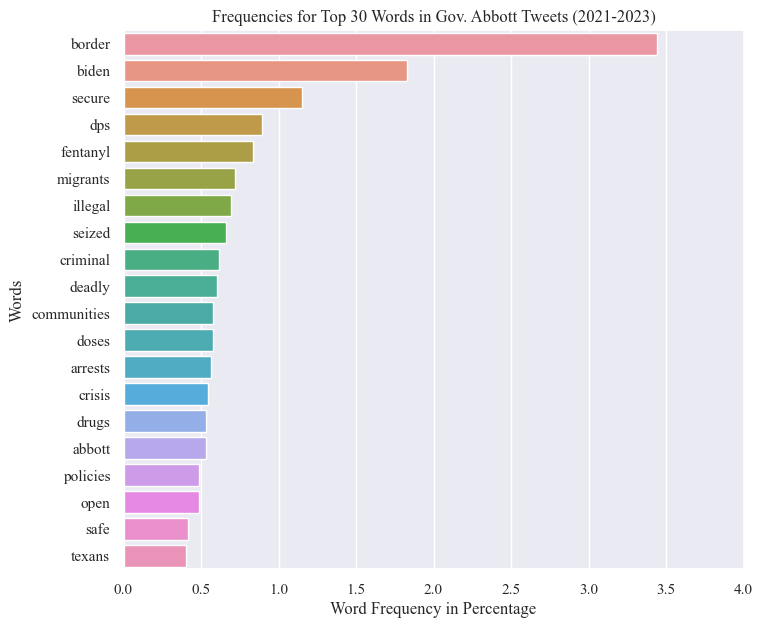

In [15]:
top_words = [(k ,(v/total_words)*100) for k, v in total_freqs.most_common(20)]
sns.set(font='Times New Roman')

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in top_words], 
            y=[w[0] for w in top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in Gov. Abbott Tweets (2021-2023)')
ax.set_xlim(0,4)

plt.savefig('images/Tweets/Gov_freqs_all.png', bbox_inches='tight')
plt.show()

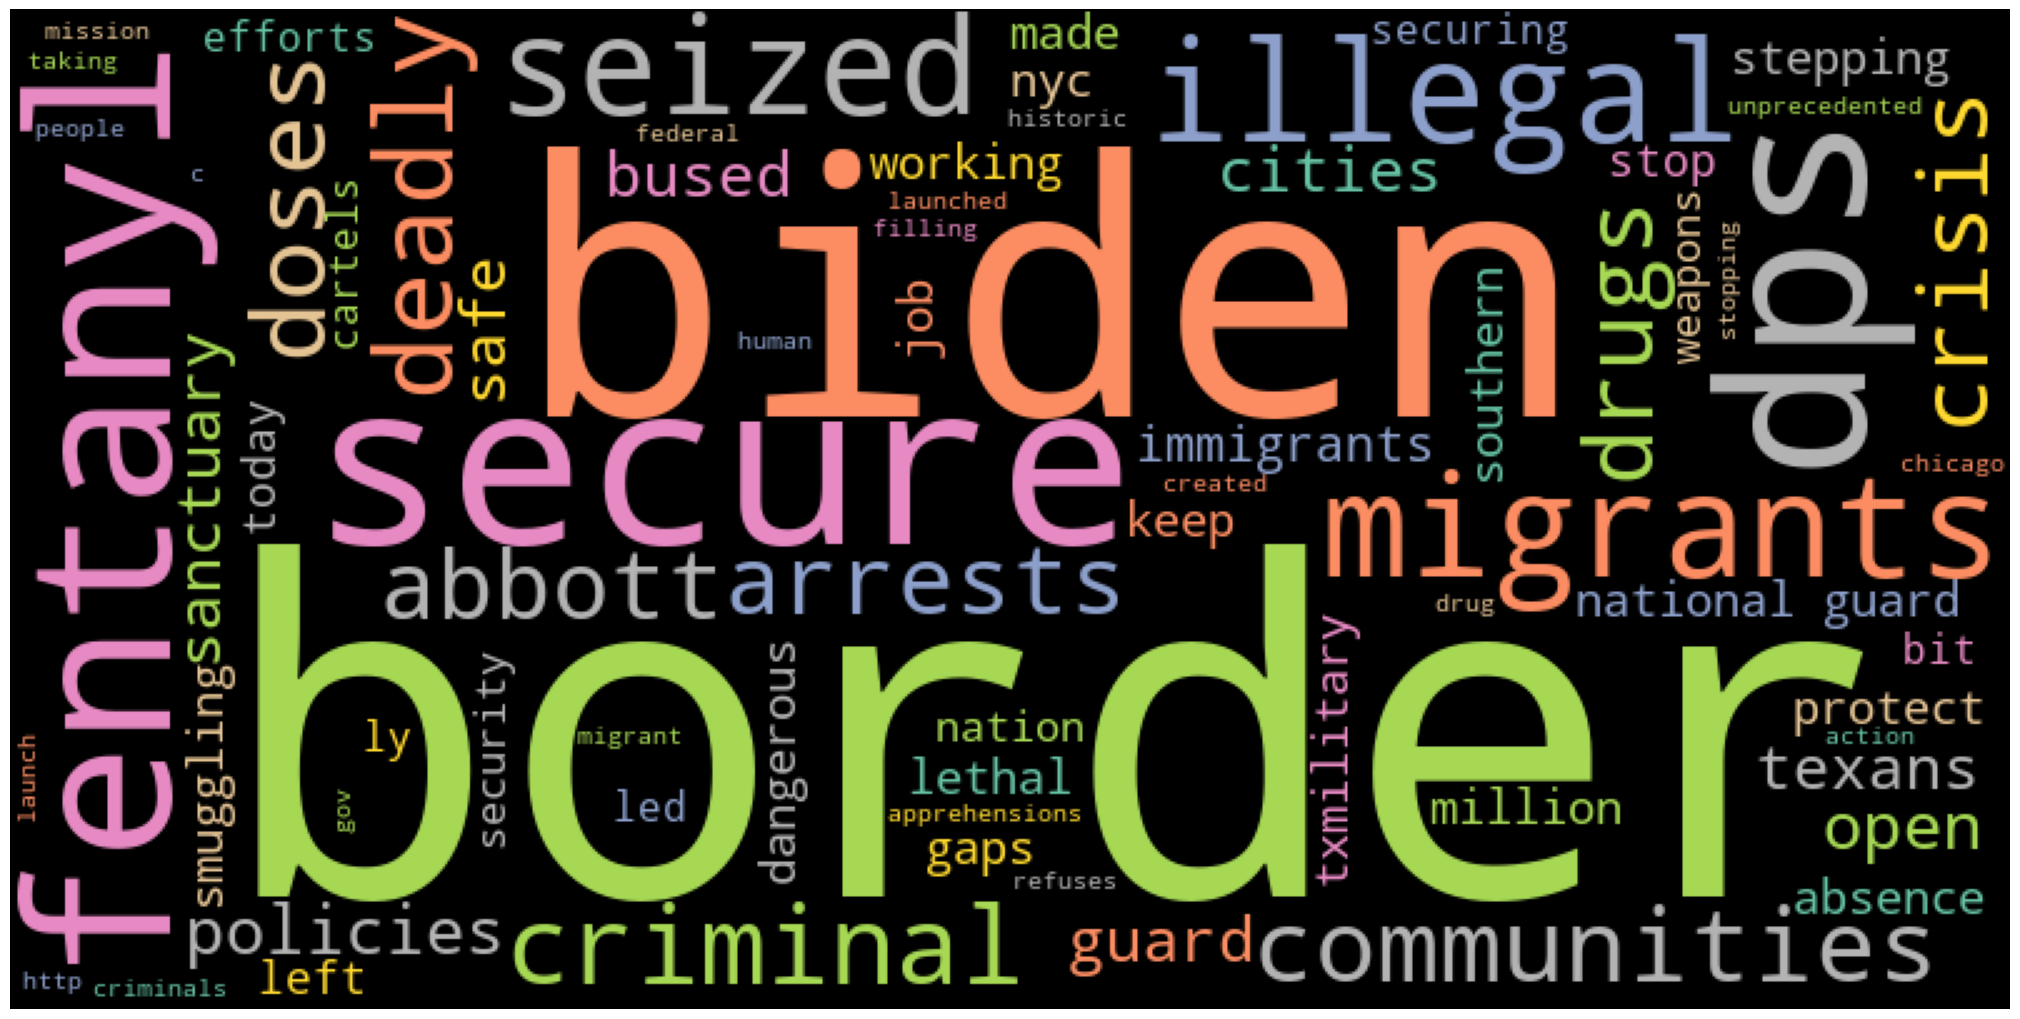

In [16]:
from wordcloud import WordCloud

top_words = total_freqs.most_common(75)
gov_dict = {}
for k, v in top_words:
    gov_dict[k] = v

word_cloud = WordCloud(min_font_size=7, background_color='black', colormap='Set2', width=800, height=400).generate_from_frequencies(gov_dict)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('images/Tweets/Gov_word_cloud.png', dpi=500)
plt.show()

In [17]:
import re

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [18]:
# 3-gram analysis
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


stop_words = set(stopwords.words('english'))
new_words = {'operation', 'lone', 'star', 's', 'operationlonestar'}
stop_words = stop_words.union(new_words)

tweets['Title'] = tweets['Title'].apply(remove_urls)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
trigrams = []

for _, row in tweets.iterrows():
    
    tokens = tokenizer.tokenize(row['Title'].lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    tri = ngrams(filtered_tokens, 3)
    trigrams += tri
    
print(trigrams[:10])

[('texas', 'securing', 'southern'), ('securing', 'southern', 'border'), ('southern', 'border', 'keeping'), ('border', 'keeping', 'communities'), ('keeping', 'communities', 'safe'), ('communities', 'safe', 'influx'), ('safe', 'influx', 'illegal'), ('influx', 'illegal', 'drugs'), ('illegal', 'drugs', 'people'), ('drugs', 'people', 'coming')]


In [19]:
from collections import Counter

trigram_freq = Counter(trigrams)
print(trigram_freq.most_common(10))

[(('open', 'border', 'policies'), 33), (('biden', 'open', 'border'), 23), (('texas', 'national', 'guard'), 20), (('migrants', 'sanctuary', 'cities'), 18), (('bused', 'migrants', 'sanctuary'), 15), (('fentanyl', 'doses', 'seized'), 12), (('lethal', 'fentanyl', 'doses'), 12), (('deadly', 'fentanyl', 'doses'), 11), (('doses', 'seized', 'migrants'), 11), (('deadly', 'drugs', 'weapons'), 10)]


In [20]:
print("3-grams for gov. Abbott tweets")
for tri, freq in trigram_freq.most_common(15):
    print(f'{tri}: {freq}')

3-grams for gov. Abbott tweets
('open', 'border', 'policies'): 33
('biden', 'open', 'border'): 23
('texas', 'national', 'guard'): 20
('migrants', 'sanctuary', 'cities'): 18
('bused', 'migrants', 'sanctuary'): 15
('fentanyl', 'doses', 'seized'): 12
('lethal', 'fentanyl', 'doses'): 12
('deadly', 'fentanyl', 'doses'): 11
('doses', 'seized', 'migrants'): 11
('deadly', 'drugs', 'weapons'): 10
('dangerous', 'gaps', 'left'): 10
('gaps', 'left', 'biden'): 10
('seized', 'migrants', 'bused'): 10
('secure', 'border', 'texas'): 9
('made', 'criminal', 'arrests'): 9


In [21]:
df_trigram = pd.DataFrame(list(trigram_freq.items()), columns=['Trigram', 'Frequency'])
df_top15 = df_trigram.sort_values('Frequency', ascending=False).head(15)

print("3-grams for gov. Abbott tweets")
print(df_top15)
df_top15.to_csv('Trigrams/Tweets/gov_trigrams.csv', index=False)

3-grams for gov. Abbott tweets
                           Trigram  Frequency
207       (open, border, policies)         33
368          (biden, open, border)         23
38        (texas, national, guard)         20
836  (migrants, sanctuary, cities)         18
835   (bused, migrants, sanctuary)         15
967      (lethal, fentanyl, doses)         12
868      (fentanyl, doses, seized)         12
869      (doses, seized, migrants)         11
723      (deadly, fentanyl, doses)         11
870      (seized, migrants, bused)         10
811            (gaps, left, biden)         10
810        (dangerous, gaps, left)         10
751       (deadly, drugs, weapons)         10
948     (filling, dangerous, gaps)          9
290      (made, criminal, arrests)          9


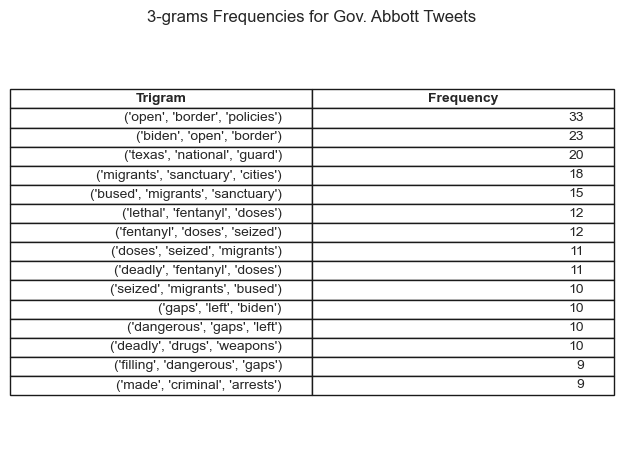

In [22]:
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df_top15.values, colLabels=df_top15.columns, loc='center')
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
ax.set(title='3-grams Frequencies for Gov. Abbott Tweets')
fig.tight_layout()
plt.savefig('table.png', dpi=200)
plt.show()


In [24]:
def TupleToString(tup):
    a, b, c = t
    return f'({a}, {b}, {c})'

In [25]:
t = ('a', 'b', 'c')
s = TupleToString(t)
type(s)

str

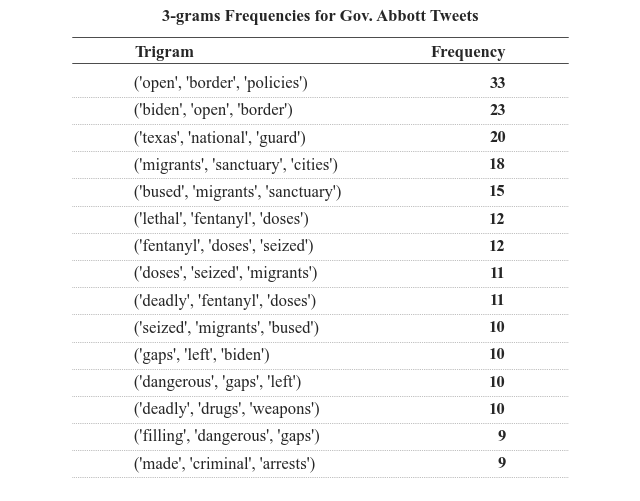

In [26]:
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(8,6))
rows = len(df_top15)
cols = len(df_top15.columns)

ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + .5)

for i, (_, row) in enumerate(df_top15.iterrows()):

    ax.text(x=.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=2, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
ax.text(.5, 15, 'Trigram', weight='bold', ha='left')
ax.text(2, 15, 'Frequency', weight='bold', ha='right')

for row in range(rows):
    ax.plot(
        [cols-1.75, cols+0.25],
        [row -.5, row - .5],
        ls=':',
        lw='.5',
        c='grey'
    )
    
ax.plot([cols-1.75, cols+0.25], [14.75, 14.75], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [14.65, 14.65], lw='.5', c='black')

ax.plot([cols-1.75, cols+0.25], [15.7, 15.7], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [15.6, 15.6], lw='.5', c='black')

ax.axis('off')
ax.set_title(
    '3-grams Frequencies for Gov. Abbott Tweets',
    loc='center',
    fontsize=12,
    weight='bold'
)

plt.savefig('Trigrams/Tweets/gov_trigrams.png')

In [178]:
tweets.groupby(['Date']).count()['Title']

dates = pd.DataFrame()

campaign_tweets['Date'] = pd.to_datetime(campaign_tweets['Date'], format='%m/%d/%Y')
abbot_tweets['Date'] = pd.to_datetime(abbot_tweets['Date'], format='%Y-%m-%d')
gov_tweets['Date'] = pd.to_datetime(gov_tweets['Date'], format='%Y-%m-%d')

dates['month'] = pd.concat([gov_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y')),
                            abbot_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y')),
                            campaign_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y'))], 
                           ignore_index=True)

# dates['Year'] = pd.concat([gov_tweets['Date'].apply(lambda x: datetime.strftime(x, '%Y')),
#                             abbot_tweets['Date'].apply(lambda x: datetime.strftime(x, '%Y')),
#                             campaign_tweets['Date'].apply(lambda x: datetime.strftime(x, '%Y'))], 
                           # ignore_index=True)
grouped_dates = dates.groupby('month').size().reset_index(name='gov')
grouped_dates

month  gov
0   Apr 21    7
1   Apr 22    5
2   Aug 21    2
3   Aug 22   11
4   Dec 21    3
5   Dec 22   20
6   Feb 23   19
7   Jan 22    2
8   Jan 23   11
9   Jul 21    1
10  Jul 22   18
11  Jun 22    5
12  Mar 21    3
13  Mar 22   10
14  May 21    5
15  May 22    3
16  Nov 21    1
17  Nov 22   12
18  Oct 21    8
19  Oct 22   18
20  Sep 21    8
21  Sep 22   15

AttributeError: 'BarContainer' object has no attribute 'set_xlabel'

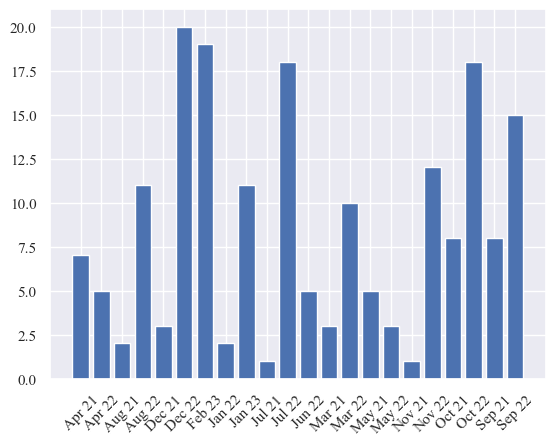

In [182]:
sns.set(style="darkgrid")
my_palette = ['#7EC2CA']
sns.set(font='Times New Roman')

ax = plt.bar(grouped_dates['month'], grouped_dates['gov'])

plt.xticks(rotation=45)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Press Releases')
ax.set_title('Number of Press Releases Per Month (2021-2023)')
ax.legend()

plt.show()

TODO:
- look into quality control: send code to Dr. Lin to ensure that its good

TODO:
- way that a state can request fed funding under an tmd act "drug interdiction and counterdrug activities" -> no request made, not stated in any press release -> false
- send summary of methodology 
- graph for abbotts top 10 word frequencies compared with DPS top 10 -> Figure 4 -- do for Press Releases and Tweets
- create graph comparing frequency of all twitter posts (like w press releases)

## DPS Tweets

In [188]:
dps_tweets = pd.read_csv('archive/Twitter/TxDPS-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title', 'Date'])

In [189]:
len(dps_tweets)

181

In [190]:
dps_tweets.head()

Publication Year     Author  \
0              2022  Texas DPS   
1              2022  Texas DPS   
2              2022  Texas DPS   
3              2022  Texas DPS   
4              2022  Texas DPS   

                                               Title Publication Title  \
0  Courtesy | Service | Protection Whether workin...            @TxDPS   
1  As part of our mission under Gov. @GregAbbott_...            @TxDPS   
2  DPS Aircraft play a vital role in supporting t...            @TxDPS   
3  DPS continues to step up to the plate as part ...            @TxDPS   
4  ICYMI: DPS & TMD Stop Large Migrant Groups in ...            @TxDPS   

         Date  
0  2022-03-18  
1  2022-03-17  
2  2022-03-16  
3  2022-03-15  
4  2022-03-09

In [30]:
years = [2021, 2022, 2023]
dps_dict = {}

for year in years:
    dps_year = " ".join(dps_tweets[dps_tweets['Publication Year'] == year]['Title'])
    dps_dict[year] = dps_year.lower()

In [31]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'tx', 'operation', 'lone', 'star', 'us', 'ols', 'said', 'state', 'pdf', 'adobe', 'reader', 'one',
            'two', 'u', 'https', 'co', 'operationlonestar', 'abbottabbott', 'keep', 'continue', 'made', 'day'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')

pattern = [r'\bopen\sborder\b']
dps_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'request': ['requests'],
    'abbott': ['gregabbott_tx', 'govabbott', 'governor abbott', 'governor'],
    'biden': ['president'],
    'continue': ['continues']
}

for year, text in dps_dict.items():
    
    # replace similar words and phrases together
    t = re.sub(r"http\S+", "", text)
    t = rep(t, words_to_replace)
    
    tokens = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(tokens)):
        if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        else:
            new_tokens.append(tokens[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    dps_freqs[year] = fdist
    
    
for k, v in dps_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

2021 :
dps: 101
abbott: 84
border: 62
gov: 46
secure: 26
part: 24
troopers: 22
drugs: 20
work: 20
briefing: 19

2022 :
dps: 58
abbott: 57
border: 47
gov: 42
secure: 27
part: 23
working: 21
mission: 20
protect: 19
drugs: 18

2023 :
abbott: 2
dps: 1
seized: 1
million: 1
lethal: 1
doses: 1
fentanyl: 1
since: 1
launched: 1
onepillkills: 1



In [32]:
dps_words_2021 = [(k ,(v/total_words[0])*100) for k, v in dps_freqs[2021].most_common(20)]
dps_words_2022 = [(k ,(v/total_words[1])*100) for k, v in dps_freqs[2022].most_common(20)]
dps_words_2023 = [(k ,(v/total_words[2])*100) for k, v in dps_freqs[2023].most_common(20)]
sns.set(font='Times New Roman')

# Create a bar plot of the most common words
fig, axes = plt.subplots(2,1,figsize=(8,14))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in dps_words_2021], 
            y=[w[0] for w in dps_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in DPS Tweets (2021)')
axes[0].set_xlim(0,3.5)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in dps_words_2022], 
            y=[w[0] for w in dps_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in DPS Tweets (2022)')
axes[1].set_xlim(0,3.5)

# sns.barplot(ax = axes[2], 
#             x=[w[1] for w in dps_words_2023], 
#             y=[w[0] for w in dps_words_2023])
# axes[2].set(xlabel='Word Frequency in Percentage',
#             ylabel='Words',
#             title='Frequencies for Top 30 Words in DPS Tweets (2023)')
# axes[2].set_xlim(0,4)

plt.savefig('images/Tweets/DPS_freqs_years.png', bbox_inches='tight')
plt.show()

In [33]:
dps_all_text = " ".join(dps_tweets['Title']).lower()

dps_all_text = re.sub(r"http\S+", "", dps_all_text)
dps_all_text = rep(dps_all_text, words_to_replace)

tokens = tokenizer.tokenize(dps_all_text)

new_tokens = []
for i in range(len(tokens)):
    if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    else:
        new_tokens.append(tokens[i])

filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(new_tokens)
fdist = FreqDist(filtered_tokens)
dps_total_freqs = fdist


for word, frequency in dps_total_freqs.most_common(10):
    print(f"{word}: {frequency}")

dps: 160
abbott: 143
border: 109
gov: 88
secure: 53
part: 47
drugs: 38
working: 36
work: 36
mission: 33


In [34]:
dps_top_words = [(k ,(v/total_words)*100) for k, v in dps_total_freqs.most_common(20)]
sns.set(font='Times New Roman')

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in dps_top_words], 
            y=[w[0] for w in dps_top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in DPS Tweets (2021-2023)')
ax.set_xlim(0,4)

plt.savefig('images/Tweets/DPS_freqs_all.png', bbox_inches='tight')
plt.show()

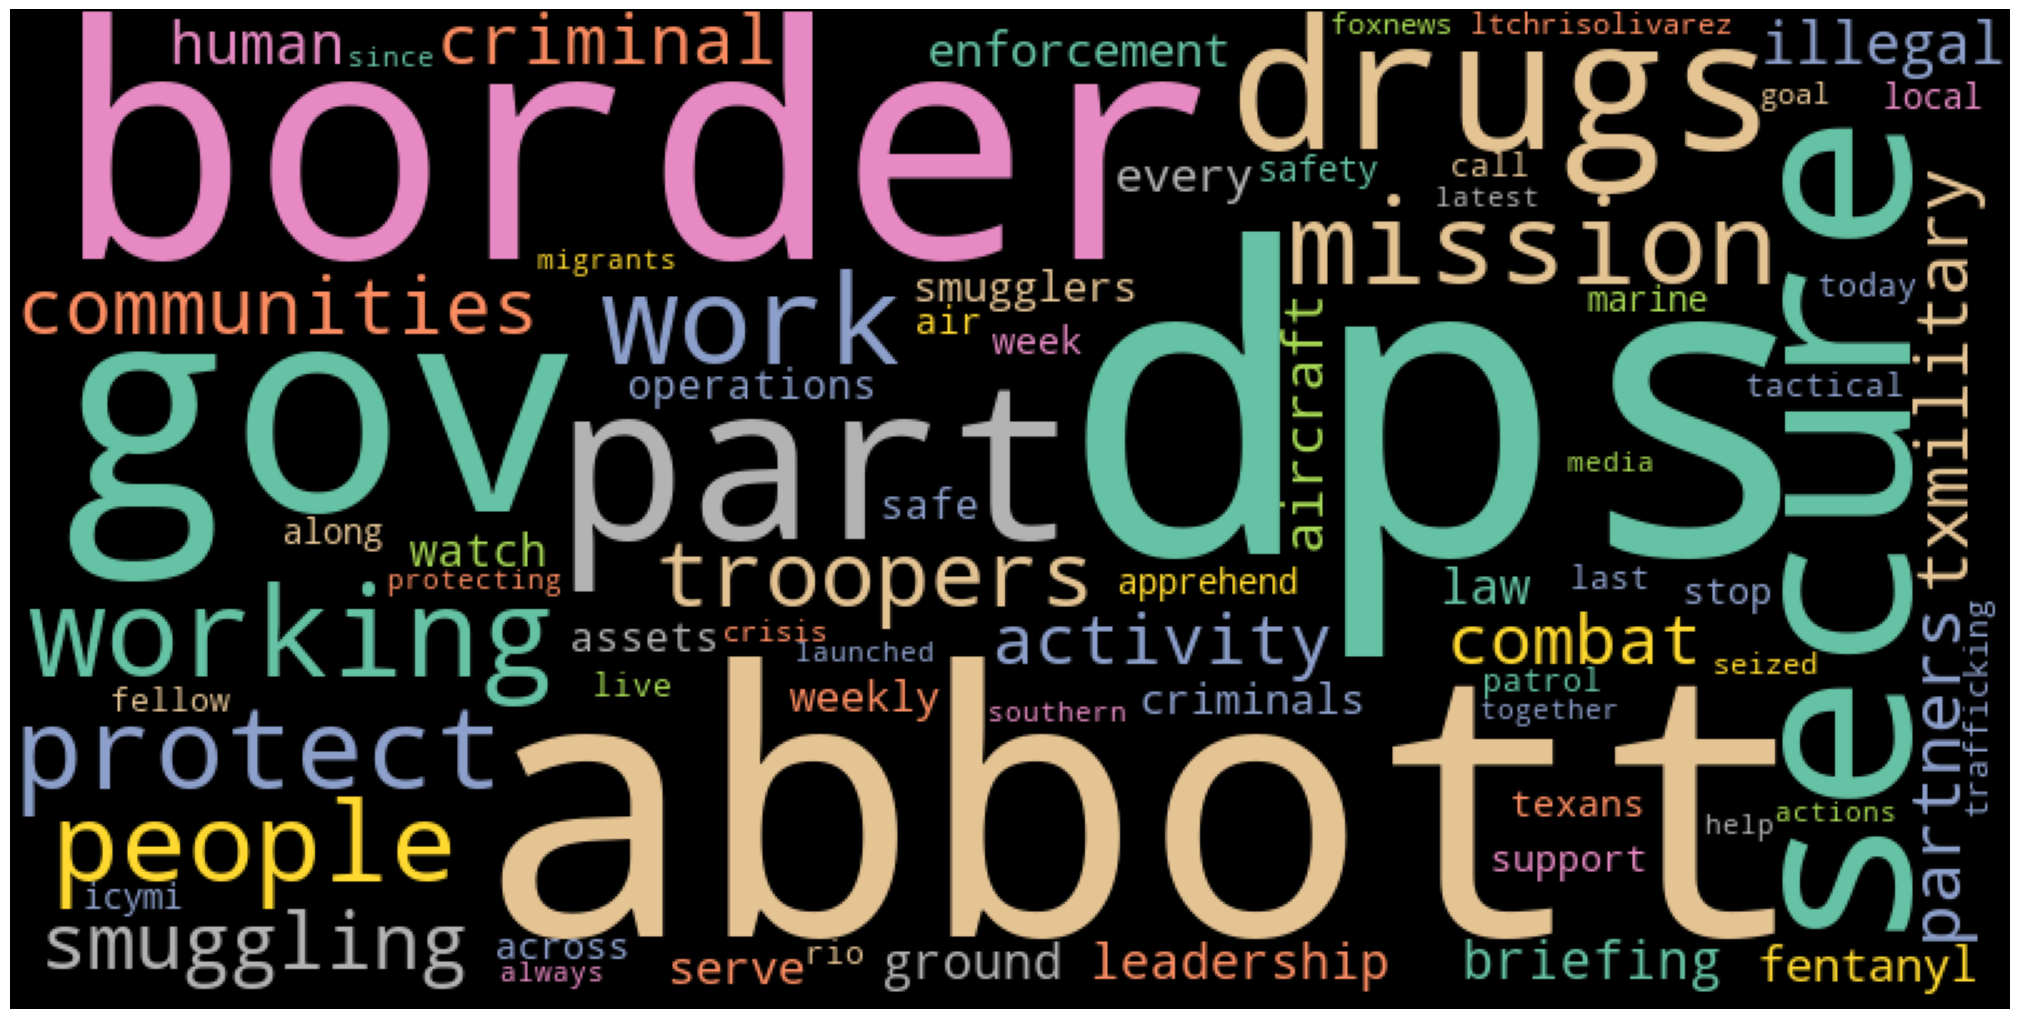

In [35]:
from wordcloud import WordCloud

dps_top_words = dps_total_freqs.most_common(75)
dps_dict = {}
for k, v in dps_top_words:
    dps_dict[k] = v

word_cloud = WordCloud(min_font_size=5, background_color='black', colormap='Set2', width=800, height=400).generate_from_frequencies(dps_dict)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('images/Tweets/DPS_word_cloud.png', dpi=500)
plt.show()

In [36]:
# 3-gram analysis
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


stop_words = set(stopwords.words('english'))
new_words = {'operation', 'lone', 'star', 's', 'operationlonestar', 'gregabbott_tx'}
stop_words = stop_words.union(new_words)

dps_tweets['Title'] = dps_tweets['Title'].apply(remove_urls)


tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
dps_trigrams = []

for _, row in dps_tweets.iterrows():
    
    tokens = tokenizer.tokenize(row['Title'].lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    tri = ngrams(filtered_tokens, 3)
    dps_trigrams += tri
    
print(dps_trigrams[:10])

[('courtesy', 'service', 'protection'), ('service', 'protection', 'whether'), ('protection', 'whether', 'working'), ('whether', 'working', 'border'), ('working', 'border', 'part'), ('border', 'part', 'gov'), ('part', 'gov', 'patrolling'), ('gov', 'patrolling', 'roadways'), ('patrolling', 'roadways', 'spring'), ('roadways', 'spring', 'break')]


In [37]:
from collections import Counter

dps_trigram_freq = Counter(dps_trigrams)
print(dps_trigram_freq.most_common(10))

[(('smuggling', 'people', 'drugs'), 14), (('people', 'drugs', 'texas'), 10), (('combat', 'smuggling', 'people'), 10), (('dps', 'continues', 'work'), 8), (('border', 'part', 'gov'), 7), (('law', 'enforcement', 'partners'), 7), (('every', 'day', 'dps'), 7), (('secure', 'border', 'gov'), 7), (('secure', 'border', 'protect'), 7), (('work', 'secure', 'border'), 7)]


In [129]:
df_dps_trigram = pd.DataFrame(list(dps_trigram_freq.items()), columns=['Trigram', 'Frequency'])
dps_top15 = df_dps_trigram.sort_values('Frequency', ascending=False).head(15)

print("3-grams for DPS tweets")
print(dps_top15)
dps_top15.to_csv('Trigrams/Tweets/dps_trigrams.csv', index=False)

3-grams for DPS tweets
                            Trigram  Frequency
116      (smuggling, people, drugs)         14
117          (people, drugs, texas)         10
410     (combat, smuggling, people)         10
422          (dps, continues, work)          8
567          (work, secure, border)          7
482       (secure, border, protect)          7
131               (every, day, dps)          7
45     (law, enforcement, partners)          7
440           (secure, border, gov)          7
5               (border, part, gov)          7
235       (local, law, enforcement)          6
108          (secure, border, part)          6
515           (air, ground, marine)          6
516      (ground, marine, tactical)          5
138  (criminals, combat, smuggling)          5


In [39]:
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(8,6))
rows = len(dps_top15)
cols = len(dps_top15.columns)

ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + .5)

for i, (_, row) in enumerate(dps_top15.iterrows()):

    ax.text(x=.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=2, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
ax.text(.5, 15, 'Trigram', weight='bold', ha='left')
ax.text(2, 15, 'Frequency', weight='bold', ha='right')

for row in range(rows):
    ax.plot(
        [cols-1.75, cols+0.25],
        [row -.5, row - .5],
        ls=':',
        lw='.5',
        c='grey'
    )
    
ax.plot([cols-1.75, cols+0.25], [14.75, 14.75], lw='.5', c='black')

ax.plot([cols-1.75, cols+0.25], [15.7, 15.7], lw='.5', c='black')

ax.axis('off')
ax.set_title(
    '3-grams Frequencies for DPS Tweets',
    loc='center',
    fontsize=12,
    weight='bold'
)

plt.savefig('Trigrams/Tweets/dps_trigrams.png')

## TMD Tweets

In [183]:
tmd_tweets = pd.read_csv('archive/Twitter/TxMilitary-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title', 'Date'])

In [184]:
len(tmd_tweets)

53

In [185]:
tmd_tweets.head()

Publication Year                              Author  \
0              2022                Texas Military Dept.   
1              2022  Texas Military Dept. [@TXMilitary]   
2              2022  Texas Military Dept. [@TXMilitary]   
3              2022  Texas Military Dept. [@TXMilitary]   
4              2022  Texas Military Dept. [@TXMilitary]   

                                               Title Publication Title  \
0  Members of the #OperationLoneStar Elite Brush ...       @TXMilitary   
1  The Texas Guard continues to work with the @Tx...           Twitter   
2  #Texas #NationalGuard Members Mobilized in Sup...           Twitter   
3  Why We’re Here – #OperationLoneStar "We're try...           Twitter   
4  Working side-by-side with the @TxDPS on #Opera...           Twitter   

         Date  
0  2022-03-29  
1  2022-03-31  
2  2022-02-03  
3  2022-01-24  
4  2022-03-28

In [186]:
mask = tmd_tweets['Author'].str.contains(r'\ATexas Military Dept.\Z')
tmd_tweets.loc[mask, 'Author'] = tmd_tweets.loc[mask, 'Author'].str.replace('Texas Military Dept.', 'Texas Military Dept. [@TXMilitary]', regex=True)

In [187]:
tmd_tweets.groupby('Author').count()

Publication Year  Title  \
Author                                                        
Texas Military Dept. [@TXMilitary]                53     53   

                                    Publication Title  Date  
Author                                                       
Texas Military Dept. [@TXMilitary]                 53    53

In [45]:
years = [2021, 2022, 2023]
tmd_dict = {}

for year in years:
    tmd_year = " ".join(tmd_tweets[tmd_tweets['Publication Year'] == year]['Title'])
    tmd_dict[year] = tmd_year.lower()

In [46]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'operation', 'lone', 'star', 'us', 'austin', 'https', 'co', 'operationlonestar', 'abbottabbott',
            'keep', 'made', 'along', 'gregabbott_texas', 'members', 'grande', 'side'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')

pattern = [r'\btexas\smilitary\sdepartment\b', r'\barmy\snational\sguard\b', r'\bnational\sguard\b', 
           r'\department\sof\spublic\ssafety\b', r'\btexas\sair\snational\sguard\b', r'\bair\snational\sguard\b',
           r'\btexas\sstate\sguard\b', r'\brio\sgrande\b']
tmd_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'abbott': ['governor abbott', 'governor', 'gov'],
    'biden': ['president', 'pres'],
    'tmd': ['texas military department'],
    'national guard': ['txng', 'texas national guard', 'txarng', 'army national guard', 'txang', 'texas army national guard'],
    'state guard': ['txsg', 'texas state guard'],
    'continue': ['continues'],
    'trafficking': ['human trafficking'],
    'texas': ['tx'],
    'rio grande': ['rio grande river', 'river']
}

for year, text in tmd_dict.items():
    
    # replace similar words and phrases together
    t = re.sub(r"http\S+", "", text)
    t = rep(t, words_to_replace)
    
    words = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(words)):
        if i < len(words)-2 and re.match(pattern[0], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[1], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[2], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        elif i < len(words)-3 and re.match(pattern[3], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-3 and re.match(pattern[4], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-2 and re.match(pattern[5], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[6], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[7], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        else:
            new_tokens.append(words[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    tmd_freqs[year] = fdist
    
    
for k, v in tmd_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

2021 :
border: 14
support: 5
smuggling: 5
trafficking: 5
securingtexas: 5
texansservingtexas: 4
dps: 4
illegal: 4
crossings: 4
southern: 4

2022 :
border: 32
mexico: 22
guard: 17
support: 15
dps: 14
criminal: 13
illegal: 13
texansservingtexas: 11
rio grande: 11
texasmilitary: 10

2023 :



In [47]:
tmd_words_2021 = [(k ,(v/total_words[0])*100) for k, v in tmd_freqs[2021].most_common(20)]
tmd_words_2022 = [(k ,(v/total_words[1])*100) for k, v in tmd_freqs[2022].most_common(20)]
sns.set(font='Times New Roman')

# Create a bar plot of the most common words
fig, axes = plt.subplots(2,1,figsize=(8,14))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in tmd_words_2021], 
            y=[w[0] for w in tmd_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in TMD Tweets (2021)')
axes[0].set_xlim(0,4.5)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in tmd_words_2022], 
            y=[w[0] for w in tmd_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in TMD Tweets (2022)')
axes[1].set_xlim(0,3.5)

plt.savefig('images/Tweets/TMD_freqs_years.png', bbox_inches='tight')
plt.show()

In [49]:
tmd_all_text = " ".join(tmd_tweets['Title']).lower()

tmd_all_text = re.sub(r"http\S+", "", tmd_all_text)
tmd_all_text = rep(tmd_all_text, words_to_replace)

words = tokenizer.tokenize(tmd_all_text)

new_tokens = []
for i in range(len(words)):
        if i < len(words)-2 and re.match(pattern[0], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[1], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[2], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        elif i < len(words)-3 and re.match(pattern[3], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-3 and re.match(pattern[4], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-2 and re.match(pattern[5], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[6], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[7], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        else:
            new_tokens.append(words[i])
filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(new_tokens)
fdist = FreqDist(filtered_tokens)
tmd_total_freqs = fdist


for word, frequency in tmd_total_freqs.most_common(20):
    print(f"{word}: {frequency}")

border: 46
mexico: 25
support: 20
guard: 19
dps: 18
illegal: 17
criminal: 16
texansservingtexas: 15
texasmilitary: 13
activity: 11
rio grande: 11
national guard: 10
state: 10
guardsmen: 9
mission: 9
southern: 8
trafficking: 8
crossings: 8
migration: 8
teams: 7


In [50]:
tmd_top_words = [(k ,(v/total_words)*100) for k, v in tmd_total_freqs.most_common(20)]
sns.set(font='Times New Roman')

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in tmd_top_words], 
            y=[w[0] for w in tmd_top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in TMD Tweets (2021-2023)')
ax.set_xlim(0,3.5)

plt.savefig('images/Tweets/TMD_freqs_all.png', bbox_inches='tight')
plt.show()

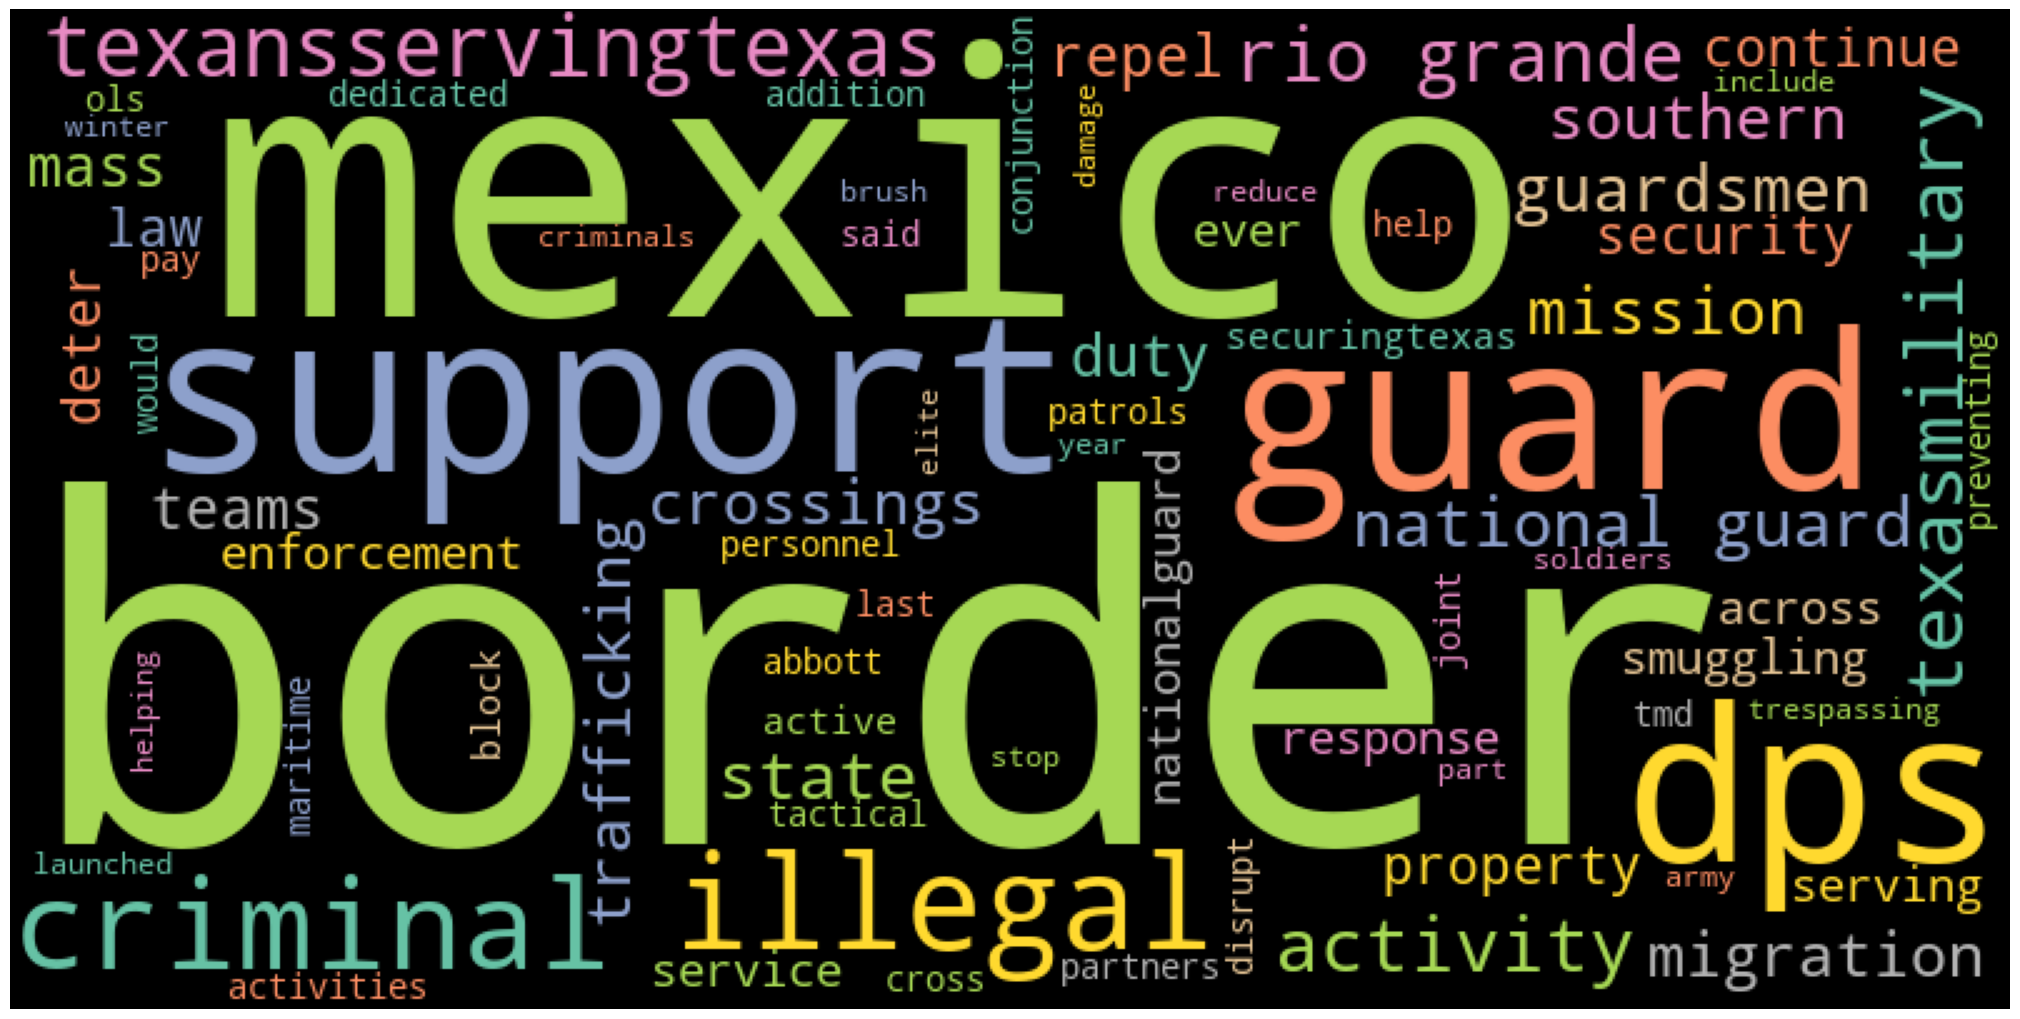

In [51]:
from wordcloud import WordCloud

tmd_top_words = tmd_total_freqs.most_common(75)
tmd_dict = {}
for k, v in tmd_top_words:
    tmd_dict[k] = v

word_cloud = WordCloud(min_font_size=5, background_color='black', colormap='Set2', width=800, height=400).generate_from_frequencies(tmd_dict)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('images/Tweets/TMD_word_cloud.png', dpi=500)
plt.show()

In [52]:
# 3-gram analysis
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


stop_words = set(stopwords.words('english'))
new_words = {'operation', 'lone', 'star', 's', 'operationlonestar', 'gregabbott_tx'}
stop_words = stop_words.union(new_words)

tmd_tweets['Title'] = tmd_tweets['Title'].apply(remove_urls)


tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
tmd_trigrams = []

for _, row in tmd_tweets.iterrows():
    
    tokens = tokenizer.tokenize(row['Title'].lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    tri = ngrams(filtered_tokens, 3)
    tmd_trigrams += tri
    
print(tmd_trigrams[:10])

[('members', 'elite', 'brush'), ('elite', 'brush', 'teams'), ('brush', 'teams', 'arrest'), ('teams', 'arrest', 'suspected'), ('arrest', 'suspected', 'criminals'), ('suspected', 'criminals', 'trespassing'), ('criminals', 'trespassing', 'private'), ('trespassing', 'private', 'property'), ('private', 'property', 'near'), ('property', 'near', 'texas')]


In [53]:
from collections import Counter

tmd_trigram_freq = Counter(tmd_trigrams)
print(tmd_trigram_freq.most_common(10))

[(('texas', 'mexico', 'border'), 21), (('along', 'texas', 'mexico'), 18), (('rio', 'grande', 'river'), 7), (('texas', 'national', 'guard'), 6), (('along', 'southern', 'border'), 5), (('state', 'active', 'duty'), 5), (('active', 'duty', 'mission'), 5), (('smuggling', 'human', 'trafficking'), 4), (('illegal', 'border', 'crossings'), 4), (('criminal', 'activity', 'along'), 4)]


In [127]:
df_tmd_trigram = pd.DataFrame(list(tmd_trigram_freq.items()), columns=['Trigram', 'Frequency'])
tmd_top15 = df_tmd_trigram.sort_values('Frequency', ascending=False).head(15)

print("3-grams for DPS tweets")
print(tmd_top15)
tmd_top15.to_csv('Trigrams/Tweets/tmd_trigrams.csv', index=False)

3-grams for DPS tweets
                             Trigram  Frequency
11           (texas, mexico, border)         21
99            (along, texas, mexico)         18
588             (rio, grande, river)          7
488         (texas, national, guard)          6
212          (active, duty, mission)          5
211            (state, active, duty)          5
28         (along, southern, border)          5
576          (mission, block, repel)          4
575           (duty, mission, block)          4
580       (activities, along, texas)          4
579    (criminal, activities, along)          4
578    (repel, criminal, activities)          4
577         (block, repel, criminal)          4
152  (smuggling, human, trafficking)          4
587             (along, rio, grande)          4


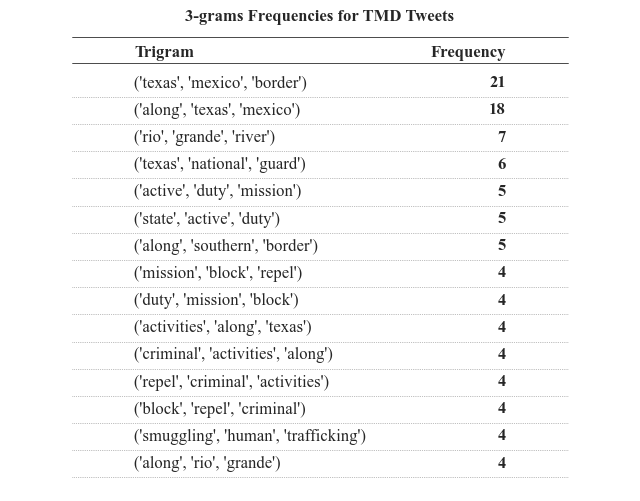

In [55]:
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(8,6))
rows = len(tmd_top15)
cols = len(tmd_top15.columns)

ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + .5)

for i, (_, row) in enumerate(tmd_top15.iterrows()):

    ax.text(x=.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=2, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
ax.text(.5, 15, 'Trigram', weight='bold', ha='left')
ax.text(2, 15, 'Frequency', weight='bold', ha='right')

for row in range(rows):
    ax.plot(
        [cols-1.75, cols+0.25],
        [row -.5, row - .5],
        ls=':',
        lw='.5',
        c='grey'
    )
    
ax.plot([cols-1.75, cols+0.25], [14.75, 14.75], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [14.65, 14.65], lw='.5', c='black')

ax.plot([cols-1.75, cols+0.25], [15.7, 15.7], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [15.6, 15.6], lw='.5', c='black')

ax.axis('off')
ax.set_title(
    '3-grams Frequencies for TMD Tweets',
    loc='center',
    fontsize=12,
    weight='bold'
)

plt.savefig('Trigrams/Tweets/tmd_trigrams.png')

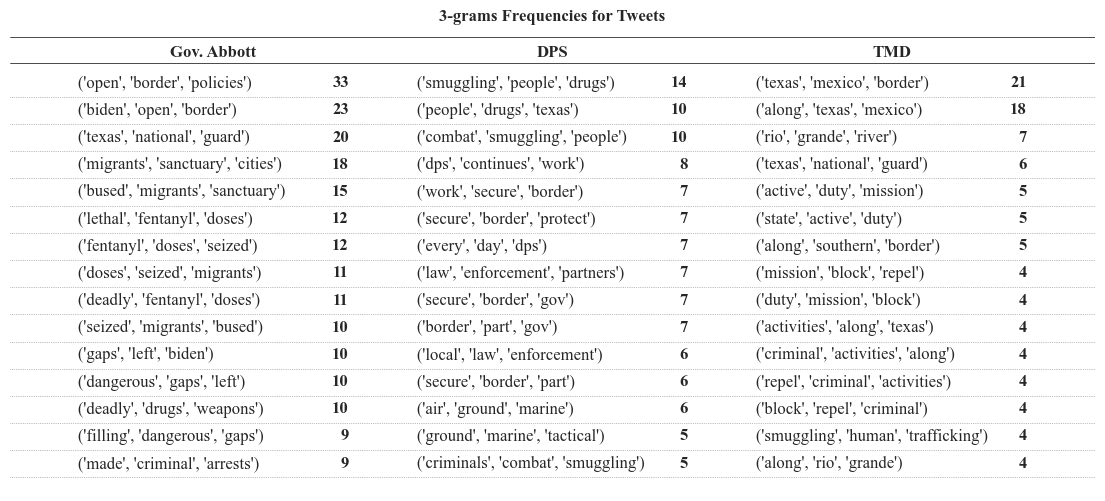

In [115]:
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(14,6))
rows = len(df_top15)
cols = len(df_top15.columns)*3

ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + 2)

for i, (_, row) in enumerate(df_top15.iterrows()):

    ax.text(x=0.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=2.5, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
for i, (_, row) in enumerate(dps_top15.iterrows()):

    ax.text(x=3, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=5, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')

for i, (_, row) in enumerate(tmd_top15.iterrows()):

    ax.text(x=5.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=7.5, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
ax.text(1.5, 15, 'Gov. Abbott', weight='bold', ha='center')
ax.text(4, 15, 'DPS', weight='bold', ha='center')
ax.text(6.5, 15, 'TMD', weight='bold', ha='center')


for row in range(rows):
    ax.plot(
        [0, cols+2],
        [row -.5, row - .5],
        ls=':',
        lw='.5',
        c='grey'
    )
    
ax.plot([0, cols+2], [14.75, 14.75], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [14.65, 14.65], lw='.5', c='black')

ax.plot([0, cols+2], [15.7, 15.7], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [15.6, 15.6], lw='.5', c='black')

ax.axis('off')
ax.set_title(
    '3-grams Frequencies for Tweets',
    loc='center',
    fontsize=12,
    weight='bold'
)

plt.savefig('Trigrams/Tweets/combined_15trigrams.png')

In [126]:
df_top10 = df_trigram.sort_values('Frequency', ascending=False).head(10)
dps_top10 = df_dps_trigram.sort_values('Frequency', ascending=False).head(10)
tmd_top10 = df_tmd_trigram.sort_values('Frequency', ascending=False).head(10)

plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(12,4))
rows = len(df_top10)
cols = len(df_top10.columns)*3

ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + 2)

for i, (_, row) in enumerate(df_top10.iterrows()):

    ax.text(x=0.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=2.5, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
for i, (_, row) in enumerate(dps_top10.iterrows()):

    ax.text(x=3, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=5, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')

for i, (_, row) in enumerate(tmd_top10.iterrows()):

    ax.text(x=5.5, y=rows-i-1, s=row['Trigram'], va='center', ha='left')
    ax.text(x=7.5, y=rows-i-1, s=row['Frequency'], va='center', ha='right', weight='bold')
    
ax.text(1.5, 10, 'Gov. Abbott', weight='bold', ha='center')
ax.text(4, 10, 'DPS', weight='bold', ha='center')
ax.text(6.5, 10, 'TMD', weight='bold', ha='center')


for row in range(rows):
    ax.plot(
        [0, cols+2],
        [row -.5, row - .5],
        ls=':',
        lw='.5',
        c='grey'
    )
    
ax.plot([0, cols+2], [-0.5, -0.5], lw='.5', c='black')

ax.plot([0, cols+2], [9.75, 9.75], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [14.65, 14.65], lw='.5', c='black')

ax.plot([0, cols+2], [10.7, 10.7], lw='.5', c='black')
# ax.plot([cols-1.75, cols+0.25], [15.6, 15.6], lw='.5', c='black')

ax.axis('off')
ax.set_title(
    '3-grams Frequencies for Tweets',
    loc='center',
    fontsize=12,
    weight='bold'
)

plt.savefig('Trigrams/Tweets/combined_10trigrams.png')

In [239]:
dps_dates.value_counts().reset_index()


index  Date
0   Sep 21    26
1   Dec 21    25
2   Mar 22    22
3   Nov 21    21
4   Oct 21    21
5   Feb 22    12
6   Jan 22    12
7   Mar 21    10
8   Aug 22     5
9   May 21     3
10  Aug 21     3
11  Jun 21     3
12  Feb 23     3
13  Jun 22     3
14  May 22     3
15  Jul 21     2
16  Oct 22     2
17  Jul 22     2
18  Nov 22     1
19  Sep 22     1
20  Apr 22     1

In [275]:
from datetime import datetime

dates = pd.DataFrame()

campaign_tweets['Date'] = pd.to_datetime(campaign_tweets['Date'], format='%m/%d/%Y')
abbot_tweets['Date'] = pd.to_datetime(abbot_tweets['Date'], format='%Y-%m-%d')
gov_tweets['Date'] = pd.to_datetime(gov_tweets['Date'], format='%Y-%m-%d')

dps_tweets['Date'] = pd.to_datetime(dps_tweets['Date'], format='%Y-%m-%d')
dps_dates = dps_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y'))

tmd_tweets['Date'] = pd.to_datetime(tmd_tweets['Date'], format='%Y-%m-%d')
tmd_dates = tmd_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y'))



dates['month'] = pd.concat([gov_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y')),
                            abbot_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y')),
                            campaign_tweets['Date'].apply(lambda x: datetime.strftime(x, '%b %y'))], 
                           ignore_index=True)

grouped_dates = dates.groupby('month').size().reset_index(name='gov')
grouped_dates = grouped_dates.append([{'month': 'Feb 22', 'gov': 0}, {'month': 'Jun 21', 'gov': 0}], ignore_index=True)
grouped_dates = grouped_dates.merge(dps_dates.value_counts().reset_index(), how='outer', left_on='month', right_on='index')
grouped_dates = grouped_dates.merge(tmd_dates.value_counts().reset_index(), how='outer', left_on='month', right_on='index')

del(grouped_dates['index_x'])
del(grouped_dates['index_y'])
grouped_dates = grouped_dates.fillna(0)
grouped_dates.columns = ['month', 'gov', 'dps', 'tmd']
grouped_dates = grouped_dates.astype({'gov': int, 'dps': int, 'tmd': int})

grouped_dates['month'] = pd.to_datetime(grouped_dates['month'], format='%b %y')
grouped_dates = grouped_dates.sort_values('month').reset_index(drop=True)
grouped_dates['month'] = grouped_dates['month'].apply(lambda x: datetime.strftime(x, '%b %y'))
grouped_dates = grouped_dates.set_index('month')

grouped_dates

/var/folders/1x/3hgwp10s3js66fg0lx49gfw00000gn/T/ipykernel_1302/1107816754.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_dates = grouped_dates.append([{'month': 'Feb 22', 'gov': 0}, {'month': 'Jun 21', 'gov': 0}], ignore_index=True)


gov  dps  tmd
month                
Mar 21    3   10    0
Apr 21    7    0    0
May 21    5    3    0
Jun 21    0    3    0
Jul 21    1    2    2
Aug 21    2    3    3
Sep 21    8   26    0
Oct 21    8   21    1
Nov 21    1   21    1
Dec 21    3   25    4
Jan 22    2   12    7
Feb 22    0   12    7
Mar 22   10   22    5
Apr 22    5    1    7
May 22    3    3    6
Jun 22    5    3    9
Jul 22   18    2    0
Aug 22   11    5    1
Sep 22   15    1    0
Oct 22   18    2    0
Nov 22   12    1    0
Dec 22   20    0    0
Jan 23   11    0    0
Feb 23   19    3    0

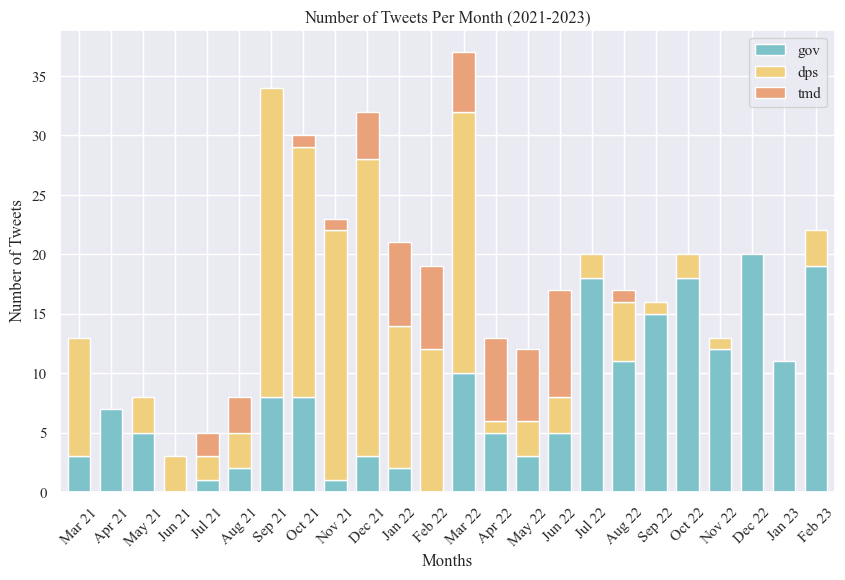

In [278]:
sns.set(style="darkgrid")
my_palette = ['#7EC2CA', '#F0D07E', '#E9A279']
sns.set(font='Times New Roman')

ax = grouped_dates.plot.bar(stacked=True, figsize=(10, 6), color=my_palette, width=0.7)

plt.xticks(rotation=45)
ax.set_xlabel('Months')
ax.set_ylabel('Number of Tweets')
ax.set_title('Number of Tweets Per Month (2021-2023)')
ax.legend()

plt.savefig('images/all_tweets.png', bbox_inches='tight')
plt.show()